In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("ECG_training.csv")
df.head()

,ECG,Classification
0,"-127,-162,-197,-229,-245,-254,-261,-265,-268,-...",N
1,"128,157,189,226,250,257,262,265,268,269,268,26...",N
2,"519,619,723,827,914,956,955,934,920,900,889,88...",A
3,"-266,-316,-367,-407,-423,-423,-401,-367,-329,-...",N
4,"21,22,24,26,28,31,32,34,34,35,35,34,34,34,35,3...",N


In [ ]:
df.shape

(3500, 2)

In [ ]:
df.describe()

,ECG,Classification
count,3500,3500
unique,3498,2
top,"-21,-23,-28,-44,-61,-72,-81,-87,-92,-96,-99,-1...",N
freq,2,3089


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ECG             3500 non-null   object
 1   Classification  3500 non-null   object
dtypes: object(2)
memory usage: 54.8+ KB


In [ ]:
print(df)

                                                    ECG Classification
0     -127,-162,-197,-229,-245,-254,-261,-265,-268,-...              N
1     128,157,189,226,250,257,262,265,268,269,268,26...              N
2     519,619,723,827,914,956,955,934,920,900,889,88...              A
3     -266,-316,-367,-407,-423,-423,-401,-367,-329,-...              N
4     21,22,24,26,28,31,32,34,34,35,35,34,34,34,35,3...              N
...                                                 ...            ...
3495  347,378,410,540,695,736,751,778,849,803,688,67...              N
3496  -59,-71,-87,-104,-111,-114,-117,-119,-120,-121...              N
3497  -60,-83,-106,-128,-145,-155,-163,-168,-173,-17...              N
3498  582,702,807,893,962,997,984,945,927,915,906,89...              N
3499  162,145,97,27,-36,-64,-90,-89,-37,61,188,324,4...              N

[3500 rows x 2 columns]


In [ ]:
lst = list(map(int, df.iloc[0,0].split(',')))
len(lst)

9000

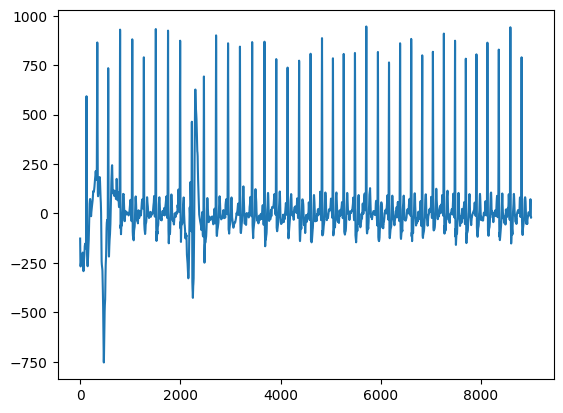

In [ ]:
plt.plot(lst)

In [ ]:
from tqdm import tqdm

for i in tqdm(range(df.shape[0]), desc="Converting"):
    lst = list(map(float, df.iloc[i,0].split(',')))
    df.iloc[i,0] = lst

Converting: 100%|██████████| 3500/3500 [00:08<00:00, 407.24it/s]


In [ ]:
df.head()

,ECG,Classification
0,"[-127.0, -162.0, -197.0, -229.0, -245.0, -254....",N
1,"[128.0, 157.0, 189.0, 226.0, 250.0, 257.0, 262...",N
2,"[519.0, 619.0, 723.0, 827.0, 914.0, 956.0, 955...",A
3,"[-266.0, -316.0, -367.0, -407.0, -423.0, -423....",N
4,"[21.0, 22.0, 24.0, 26.0, 28.0, 31.0, 32.0, 34....",N


In [ ]:
type(df.iloc[1,0])

list

In [ ]:
# Normalize ECG signals
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

df['ECG'] = df['ECG'].apply(normalize_signal)

In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import pywt
from scipy.fft import fft
from scipy.stats import kurtosis, skew
from scipy.signal import butter, lfilter, find_peaks

def bandpass_filter(signal, lowcut=0.5, highcut=50.0, fs=300, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def extract_features(signal):
    features = {}

    # Apply bandpass filter
    filtered_signal = bandpass_filter(signal) # Removes noise

    # Time-domain features
    features['length'] = len(filtered_signal)
    features['mean'] = np.mean(filtered_signal)
    features['std'] = np.std(filtered_signal)
    features['variance'] = np.var(filtered_signal)
    features['max'] = np.max(filtered_signal)
    features['min'] = np.min(filtered_signal)
    features['median'] = np.median(filtered_signal)
    features['IQR'] = np.percentile(filtered_signal, 75) - np.percentile(filtered_signal, 25)
    features['skew'] = skew(filtered_signal)
    features['kurtosis'] = kurtosis(filtered_signal)

    # RR Interval Features
    peaks, _ = find_peaks(filtered_signal, height=0.5)  # Adjust threshold as needed
    rr_intervals = np.diff(peaks) / 300.0  # Convert to seconds
    features['mean_rr_interval'] = np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
    features['std_rr_interval'] = np.std(rr_intervals) if len(rr_intervals) > 0 else 0

    # Frequency-domain features
    N = len(filtered_signal)
    T = 1.0 / 300.0  # Sampling frequency
    yf = fft(filtered_signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    features['dominant_freq'] = xf[np.argmax(np.abs(yf[:N//2]))]
    features['mean_freq'] = np.mean(xf[np.abs(yf[:N//2]) > 0.1])  # Mean of frequencies with significant amplitude

    # Wavelet Transform Features
    coeffs = pywt.wavedec(filtered_signal, 'db4', level=4)
    features['wavelet_mean'] = np.mean(coeffs[0])  # Approximation coefficients
    features['wavelet_std'] = np.std(coeffs[0])

    return features

# Example usage
df['Features'] = df['ECG'].apply(lambda x: extract_features(x))
features_df = pd.json_normalize(df['Features'])
features_df['Classification'] = df['Classification'].values

In [ ]:
features_df.head()

,length,mean,std,variance,max,min,median,IQR,skew,kurtosis,mean_rr_interval,std_rr_interval,dominant_freq,mean_freq,wavelet_mean,wavelet_std,Classification
0,9000,0.000253,0.988982,0.978085,5.777317,-2.526019,0.010262,0.607920,1.532071,5.614160,0.370542,0.272771,3.766667,34.766827,-0.015673,3.354210,N
1,9000,-0.000521,0.975045,0.950713,8.478957,-5.113649,-0.027262,0.724613,1.436119,11.868667,0.286570,0.298817,0.966667,40.987307,0.008272,3.074058,N
2,9000,0.003832,0.965094,0.931407,5.834226,-2.698776,0.046643,0.811956,2.404272,10.750900,0.427905,0.322984,1.133333,75.002639,0.063266,3.215175,A
3,9000,-0.000553,0.969917,0.940738,3.158298,-5.357957,0.249531,0.719960,-1.803581,5.341916,0.229179,0.275971,0.933333,74.986960,-0.054357,3.244267,N
4,9000,-0.003699,0.998363,0.996728,3.040762,-5.349185,-0.148637,0.869975,-1.148562,6.136299,0.424216,0.219978,1.000000,74.983333,0.013369,3.256829,N


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(features_df.drop('Classification', axis=1))
y = features_df['Classification']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

Classification Report:
              precision    recall  f1-score   support

           A       0.73      0.07      0.13       115
           N       0.90      1.00      0.94       935

    accuracy                           0.90      1050
   macro avg       0.81      0.53      0.54      1050
weighted avg       0.88      0.90      0.85      1050

Confusion Matrix:


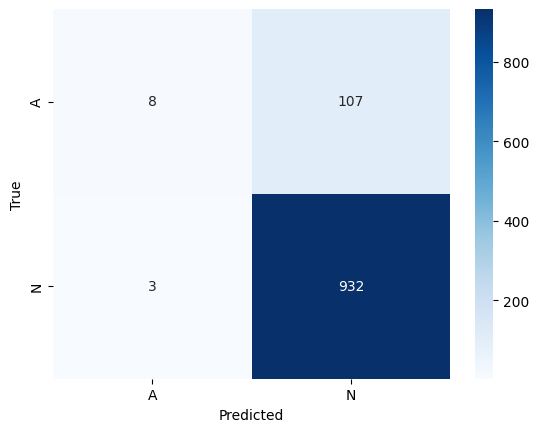

In [ ]:
# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()